<a href="https://colab.research.google.com/github/sahookarishma/sahookarishma/blob/main/Brain_tumor_data_image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [ ]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
  0% 0.00/15.1M [00:00<?, ?B/s]
100% 15.1M/15.1M [00:00<00:00, 833MB/s]


In [ ]:
import tensorflow as tf
from zipfile import ZipFile
import os,glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from zipfile import ZipFile

In [ ]:
file_name = "/content/brain-mri-images-for-brain-tumor-detection.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
# os.chdir('/content/yes')
# X = []
# y = []
# for i in tqdm(os.listdir()):
#       img = cv2.imread(i)
#       img = cv2.resize(img,(224,224))
#       X.append(img)
#       y.append((i[0:1]))
# os.chdir('/content/no')
# for i in tqdm(os.listdir()):
#       img = cv2.imread(i)
#       img = cv2.resize(img,(224,224))
#       X.append(img)
# for i in range(1,99):
#     y.append('N')
# print(y)

os.chdir('/content/yes')
X = []
y = []
for i in tqdm(os.listdir()):
      img = cv2.imread(i)
      # Check if the image was loaded successfully
      if img is not None:
          img = cv2.resize(img,(224,224))
          X.append(img)
          y.append((i[0:1]))
os.chdir('/content/no')
for i in tqdm(os.listdir()):
      img = cv2.imread(i)
      # Check if the image was loaded successfully
      if img is not None:
          img = cv2.resize(img,(224,224))
          X.append(img)
# The original code appended 'N' for a fixed range (1, 99).
# This might not correspond to the number of 'no' images actually loaded.
# Instead, append 'N' for each image successfully loaded from the 'no' directory.
# We need to adjust the 'y' list based on the number of images actually loaded from the 'no' directory.
# A simpler approach is to append 'Y' or 'N' within the loop based on the directory.
# Let's refactor the loading part to be clearer.

X = []
y = []

os.chdir('/content/yes')
print("Loading images from /content/yes")
for filename in tqdm(os.listdir()):
    img = cv2.imread(filename)
    if img is not None:
        img = cv2.resize(img, (224, 224))
        X.append(img)
        y.append('Y') # Append 'Y' for images from the 'yes' directory

os.chdir('/content/no')
print("Loading images from /content/no")
for filename in tqdm(os.listdir()):
    img = cv2.imread(filename)
    if img is not None:
        img = cv2.resize(img, (224, 224))
        X.append(img)
        y.append('N') # Append 'N' for images from the 'no' directory

print("Finished loading images.")
print(f"Total images loaded: {len(X)}")
print(f"Total labels loaded: {len(y)}")

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loading images from /content/yes


  0%|          | 0/155 [00:00<?, ?it/s]

Loading images from /content/no


  0%|          | 0/101 [00:00<?, ?it/s]

Finished loading images.
Total images loaded: 253
Total labels loaded: 253


***

```
# This is formatted as code
```

display the 4 images in train data

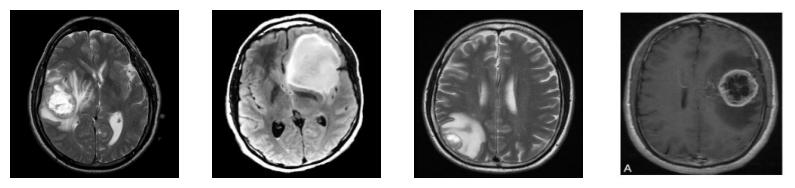

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(X[i], cmap="gray")
    plt.axis('off')
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print ("Shape of an image in X_train: ", X_train[0].shape)
print ("Shape of an image in X_test: ", X_test[0].shape)


Shape of an image in X_train:  (224, 224, 3)
Shape of an image in X_test:  (224, 224, 3)


The labels are in yes and no , so we need an encoder for converting the yes and no to 1 and 0, respectively.

In [ ]:
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

Converts the integer labels to one-hot encoded vectors, which are required for most classification models in TensorFlow/Keras.

Example:

0 → [1, 0]

1 → [0, 1]

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

converting the images into the array format by using np.array

In [ ]:
y_train = np.array(y_train)
X_train = np.array(X_train)
y_test = np.array(y_test)
X_test = np.array(X_test)
print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (169, 224, 224, 3)
X_test Shape:  (84, 224, 224, 3)
y_train Shape:  (169, 2)
y_test Shape:  (84, 2)


training the keras model

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.5329 - loss: 582.6072 - val_accuracy: 0.3929 - val_loss: 27.5194
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.4644 - loss: 17.4304 - val_accuracy: 0.8095 - val_loss: 1.1445
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.7289 - loss: 1.3133 - val_accuracy: 0.7619 - val_loss: 0.6144
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.7729 - loss: 0.5067 - val_accuracy: 0.7381 - val_loss: 0.5834
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.7882 - loss: 0.4939 - val_accuracy: 0.7619 - val_loss: 0.5321
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.8756 - loss: 0.3443 - val_accuracy: 0.6905 - val_loss: 0.7482
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.8811 - loss: 0.3354 - val_accuracy: 0.7738 - val_loss: 0.5677
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.9240 - loss: 0.2490 - val_accuracy: 0.7738 - val_loss: 0.6274
Epoc

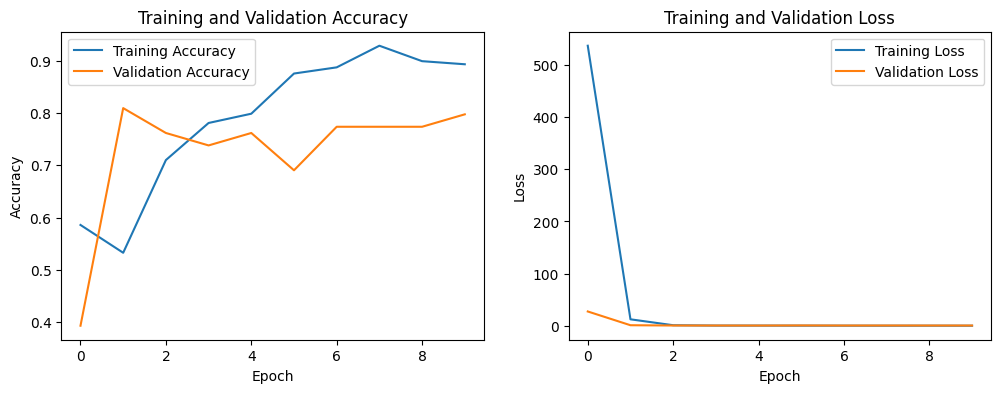

In [ ]:
# prompt: train a keras model from tensor flow using the above training and test data

import matplotlib.pyplot as plt
# Build the model
model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Training the datasets with VGG16 model

In [ ]:
from keras.applications import vgg16


img_rows, img_cols = 224, 224


vgg = vgg16.VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape = (img_rows, img_cols, 3))


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:

# Here we freeze the last 4 layers
# Layers are set to trainable as True by default
for layer in vgg.layers:
    layer.trainable = False

# Let's print our layers
for (i,layer) in enumerate(vgg.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)


0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [ ]:
def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D

from keras.models import Model


num_classes = 2

FC_Head = lw(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = FC_Head)

print(model.summary())


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 16,815,426 (64.15 MB)

 Trainable params: 2,100,738 (8.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [ ]:
from tensorflow.keras.models import Model
model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
history = model.fit(X_train,y_train,
                    epochs=5,
                    validation_data=(X_test,y_test),
                    verbose = 1,
                    initial_epoch=0)

Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 157s 27s/step - accuracy: 0.5558 - loss: 5.7262 - val_accuracy: 0.3929 - val_loss: 4.1853
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 233s 33s/step - accuracy: 0.5444 - loss: 2.1540 - val_accuracy: 0.7500 - val_loss: 0.5914
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 209s 35s/step - accuracy: 0.8101 - loss: 0.4161 - val_accuracy: 0.8452 - val_loss: 0.4642
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 192s 33s/step - accuracy: 0.9049 - loss: 0.2653 - val_accuracy: 0.8571 - val_loss: 0.3483
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 233s 38s/step - accuracy: 0.9306 - loss: 0.1820 - val_accuracy: 0.8571 - val_loss: 0.3729


In [ ]:
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
epochs = range(len(acc))

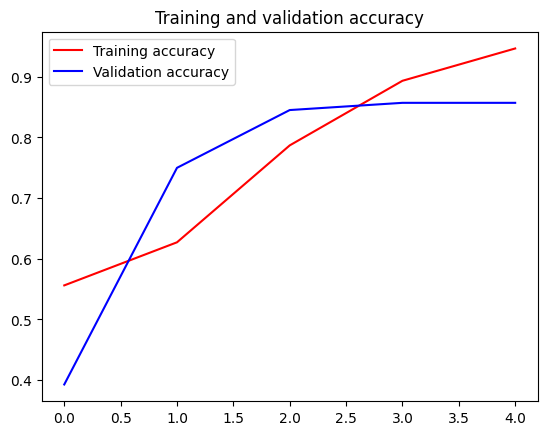

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

Learning the training of keras model using MNIST datasets

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense

In [ ]:
(X_train,y_train),(X_test,y_test) = keras.datasets.mnist.load_data()

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [ ]:
model = Sequential()
model.add(Flatten(input_shape=(224,224)))
model.add(Dense(128,activation='relu'))
model.add(Dense(10,activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,423,946 (24.51 MB)

 Trainable params: 6,423,946 (24.51 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(X_train,y_train,epochs=25, verbose = 1, batch_size=32, validation_split= 0.2)

Epoch 1/25


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("sequential_2_1/Cast:0", shape=(None, 224, 224, 3), dtype=float32). Expected shape (None, 224, 224), but input has incompatible shape (None, 224, 224, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 224, 224, 3), dtype=uint8)
  • training=True
  • mask=None

In [ ]:
model.evaluate(X_test,y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9408 - loss: 1.0708


[0.9345450401306152, 0.9498999714851379]

In [ ]:
model.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 9.9999994e-01,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 9.9999994e-01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 9.9999994e-01, 4.4501540e-38, ..., 0.0000000e+00,
        6.2319885e-32, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [ ]:
pred_probs = model.predict(X_test)
pred_classes = pred_probs.argmax(axis=-1)
print(pred_classes)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[7 2 1 ... 4 5 6]


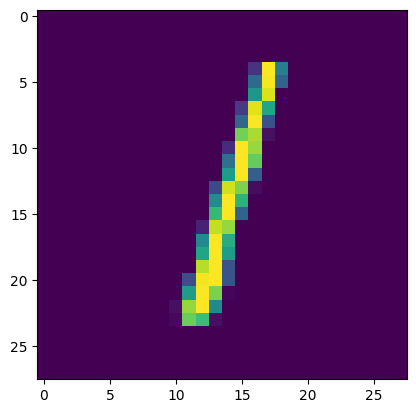

In [ ]:
plt.imshow(X_test[0])
plt.imshow(X_test[2])

learning curves

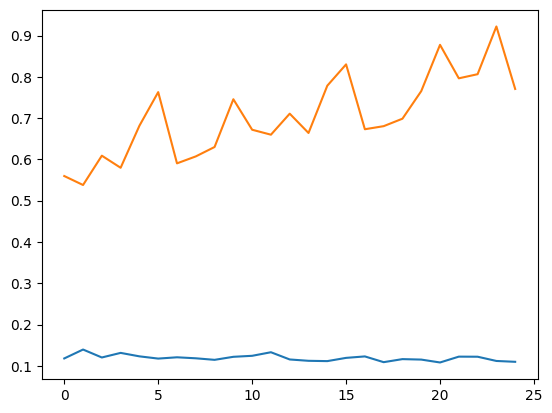

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

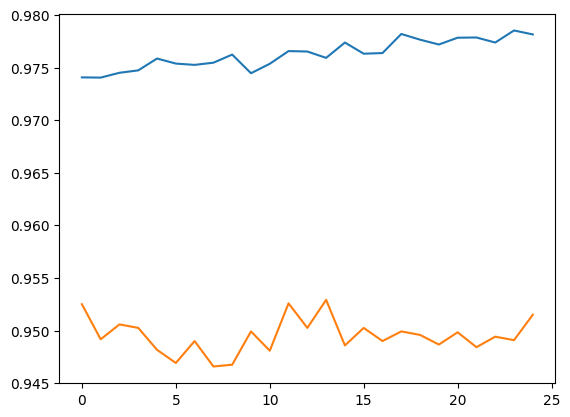

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])